# Visualize RNN Prediction

In [1]:
using Flux
using StaticArrays
using ProgressMeter
using POMDPs
using POMDPToolbox
using AutomotiveDrivingModels
using AutoViz
using AutomotivePOMDPs
using AutomotiveSensors
using PedCar
using Reel
using FileIO
using BSON: @load
include("RNNFiltering.jl")
using RNNFiltering

2018-09-26 23:05:33.707317: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [2]:
cam = FitToContentCamera(0.)
rng = MersenneTwister(1);

**environment**

In [3]:
mdp = PedCarMDP(pos_res=2.0, vel_res=2., ped_birth=0.7, car_birth=0.7)
pomdp = UrbanPOMDP(env=mdp.env,
                    sensor = GaussianSensor(false_positive_rate=0.0, 
                                            pos_noise = LinearNoise(min_noise=0.5, increase_rate=0.05), 
                                            vel_noise = LinearNoise(min_noise=0.5, increase_rate=0.05)),
                   ego_goal = LaneTag(2, 1),
                     obs_dist = ObstacleDistribution(mdp.env, upper_obs_pres_prob=0., left_obs_pres_prob=1.0, right_obs_pres_prob=1.0),
                   max_cars=1, 
                   max_peds=1, 
                   car_birth=0.05, 
                   ped_birth=0.05, 
                   max_obstacles=1, # no fixed obstacles
                   lidar=false,
                   ego_start=20,
                   ΔT=0.1)
;

In [4]:
n_models = 5
models = Vector{Chain}(n_models)
for i=1:n_models
    models[i] = BSON.load("model_$i.bson")[:model] 
end


In [5]:
# input_length = n_dims(pomdp)
# output_length = n_dims(pomdp)
# model = Chain(LSTM(input_length, 128),
#               Dense(128, output_length))

In [19]:
function RNNFiltering.process_prediction(pomdp::UrbanPOMDP, b::Vector{Float64}, o::Vector{Float64})
    n_features = 4
    n_obstacles = pomdp.max_obstacles
    b_ = zeros(length(o)) # should be 12 + obstacles
    b_[1:4] = o[1:4] # ego state fully observable
    # get car state from b
    car_presence = b[5]
    if rand() < car_presence 
        b_[n_features+1:2*n_features] = b[1:4]
    else
        # absent
        b_[n_features+1:2*n_features] = RNNFiltering.normalized_off_the_grid_pos(pomdp, o[1], o[2])
    end
    
    # get ped state from b 
    ped_presence = b[10]
    if rand() < ped_presence # softmax 
        b_[2*n_features+1:3*n_features] = b[6:9]
    else
        # absent 
        b_[2*n_features+1:3*n_features] = RNNFiltering.normalized_off_the_grid_pos(pomdp, o[1], o[2])
    end
            
    b_[end - n_features*n_obstacles + 1:end] = o[end - n_features*n_obstacles + 1:end]
    return b_
end

In [72]:
n_steps = 400
belief_history = Vector{Vector{Float64}}[]
state_history = Scene[]
obs_history = Vector{Float64}[]
presence_history = Tuple{Float64, Float64}[]
s = initial_state(pomdp, rng)
for m in models
    Flux.reset!(m)
end
@time for i=1:n_steps
    if isterminal(pomdp, s)
        break 
    end
    push!(state_history, s)
    a = UrbanAction(1.)
    o = generate_o(pomdp, s, a, s, rng)
    beliefs = Vector{Vector{Float64}}(n_models)
    car_pres, ped_pres = 0., 0.
    for i=1:n_models       
        pred = models[i](o).tracker.data
        car_pres += pred[5]
        ped_pres += pred[10]
        b_ = process_prediction(pomdp, pred, o)
        beliefs[i] = b_
    end
    push!(presence_history, (car_pres/n_models, ped_pres/n_models))
    push!(belief_history, beliefs)
    push!(obs_history, o)
    sp = generate_s(pomdp, s, a, rng)
    s = sp
end


  2.022856 seconds (4.02 M allocations: 409.176 MiB, 29.66% gc time)


In [73]:
duration, fps, render_hist = animate_scenes(state_history, obs_history, belief_history, presence_history, pomdp, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpFTtPLS", 0x0000000000000190, 10.0, nothing)

In [66]:
function AutomotivePOMDPs.animate_scenes(scenes::Vector{Scene}, observations::Vector{Vector{Float64}}, 
                                         beliefs::Vector{Vector{Vector{Float64}}}, 
                                         presences::Vector{Tuple{Float64, Float64}},
                                         pomdp::UrbanPOMDP;
                                         sim_dt = 0.1,
                                         cam = StaticCamera(VecE2(0., -8.), 16.0))
    env = pomdp.env 
    duration = length(scenes)*sim_dt
    fps = Int(1/sim_dt)
    function render_rec(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        overlays = SceneOverlay[IDOverlay()]
        obs = [veh for veh in obs_to_scene(pomdp, observations[frame_index]) if veh.id != EGO_ID]
        obs_overlay = GaussianSensorOverlay(sensor=pomdp.sensor, o=obs, color=MONOKAI["color2"])
        push!(overlays, obs_overlay)
        occlusion_overlay = OcclusionOverlay(obstacles=mdp.env.obstacles)
        push!(overlays, occlusion_overlay)
        for b in beliefs[frame_index]
            bel = [veh for veh in obs_to_scene(pomdp, b) if veh.id != EGO_ID]
            bel_overlay = GaussianSensorOverlay(sensor=pomdp.sensor, o=bel, color=MONOKAI["color4"])            
            push!(overlays, bel_overlay)
        end
        push!(overlays, HistogramOverlay(pos=VecSE2(-15., -20.), val=presences[frame_index][1], label="car"))
        push!(overlays, HistogramOverlay(pos=VecSE2(-12., -20.), val=presences[frame_index][2], label="ped"))
        push!(overlays, TextOverlay(text=["Probability of presence"], pos=VecSE2(-17,-14.), font_size=15, incameraframe=true))
        return AutoViz.render(scenes[frame_index], env, overlays, cam=cam)
    end
    return duration, fps, render_rec
end
    
    

In [34]:
using Parameters
using Cairo

In [35]:
function render_rect(ctx::CairoContext,
                    x::Real,
                    y::Real,
                    width::Real,
                    height::Real,
                    color_fill::Colorant,
                    ffill         :: Bool        = false,
                    fstroke       :: Bool        = true,
                    color_stroke  :: Colorant    = color_fill,
                    line_width    :: Real        = 2.0
                    )
    Cairo.save(ctx)
    rectangle(ctx, x, y, width, height)
    if ffill
        set_source_rgba(ctx, color_fill)
        fstroke ? fill_preserve(ctx) : fill(ctx)
    end
    
    if fstroke
        set_source_rgba(ctx, color_stroke)
        set_line_width(ctx, line_width)
        stroke(ctx)
    end
    
    restore(ctx)
end

render_rect (generic function with 5 methods)

In [41]:
@with_kw mutable struct HistogramOverlay <: SceneOverlay
    pos::VecSE2{Float64} = VecSE2(0.,0.)
    incameraframe::Bool = true
    label::String = "histogram"
    val::Float64 = 0.5 # should be between 0 and 1
    width::Float64 = 2.
    height::Float64 = 5. 
    fill_color::Colorant = colorant"blue"
    line_color::Colorant = colorant"white"
    font_size::Int64 = 15 # [pix]
    label_pos::VecSE2{Float64} = pos + VecSE2(0., -height/2)
end

function AutoViz.render!{R}(rendermodel::RenderModel, overlay::HistogramOverlay, scene::Scene, roadway::R)
    # render value 
    add_instruction!(rendermodel, render_rect, (overlay.pos.x, overlay.pos.y, overlay.width, overlay.val*overlay.height,overlay.fill_color, true, false), incameraframe=overlay.incameraframe)
    # render histogram outline 
    add_instruction!(rendermodel, render_rect, (overlay.pos.x, overlay.pos.y, overlay.width, overlay.height, overlay.line_color), incameraframe=overlay.incameraframe)
     # label 
    add_instruction!(rendermodel, render_text, (overlay.label, overlay.label_pos.x, overlay.label_pos.y, overlay.font_size, overlay.line_color), incameraframe=overlay.incameraframe)
end

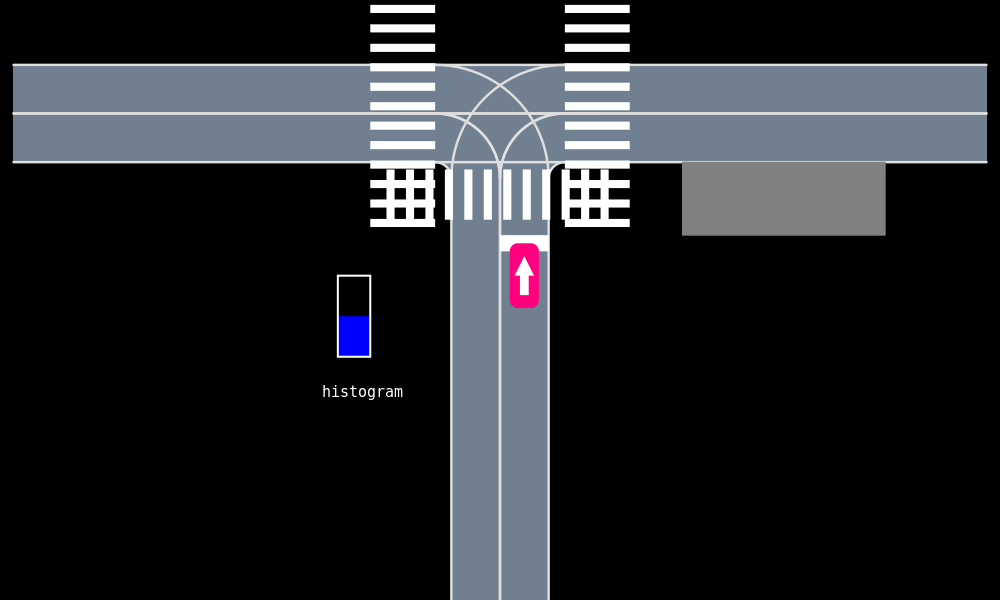

In [37]:
# test histogram overlay 
scene = state_history[1]
overlay = HistogramOverlay(pos=VecSE2(-10., -15.))
render(scene, pomdp.env, [overlay], cam=cam)

## Visualize training set

In [75]:
# include("data_generation.jl")

In [5]:
policy = RandomHoldPolicy(pomdp, 5, 0, UrbanAction(0.), rng);

In [99]:
X, Y = collect_set(pomdp, policy , 400, rng, 1);

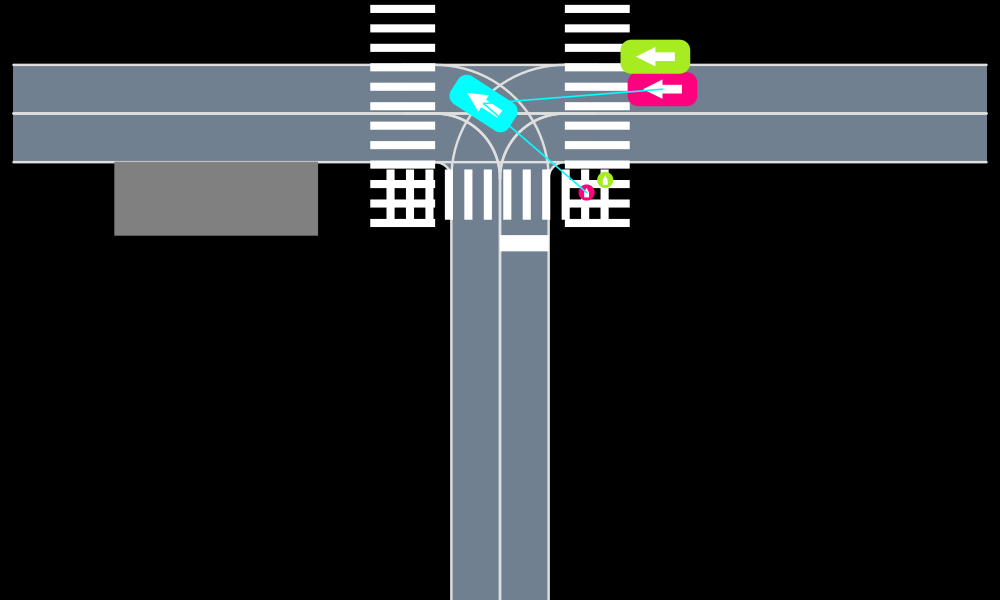

In [100]:
trajind = 1
trajx = X[trajind]
trajy = Y[trajind]
tb = process_prediction.(pomdp, trajy, trajx)
scenes = obs_to_scene.(pomdp, tb);
sind = 250
obs = [veh for veh in obs_to_scene(pomdp, trajx[sind]) if veh.id != EGO_ID]
render(scenes[sind], pomdp.env, [GaussianSensorOverlay(sensor=pomdp.sensor, o=obs, color=MONOKAI["color2"]), OcclusionOverlay(obstacles=pomdp.env.obstacles)], 
                cam=cam, car_colors=get_colors(scenes[1]))

In [89]:
duration, fps, render_hist = animate_scenes(scenes, pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmp3SYP7E", 0x0000000000000191, 10.0, nothing)

In [31]:
tx, ty = generate_trajectory(pomdp, policy, 100, rng);
tx = convert.(Vector{Float64}, tx)
duration, fps, render_hist = animate_scenes(obs_to_scene.(pomdp, tx), pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmp2F9062", 0x0000000000000065, 10.0, nothing)

In [74]:
function build_presence_mask(y::Vector{Float64}, car_pres_ind=5, ped_pres_ind=10)
    n_features = 5
    mask = ones(length(y))
    if y[car_pres_ind] == 0.
        mask[1:car_pres_ind-1] .= 0. 
    end
    if y[ped_pres_ind] == 0.
        mask[ped_pres_ind-n_features+1:ped_pres_ind-1] .= 0.
    end
    return mask
end

build_presence_mask (generic function with 6 methods)

In [116]:
model = models[1]
function loss(x, y)
    mask = build_presence_mask.(y) # same size as y
    l = mean(mse.(model.(x), y, mask)) # mean over the trajectory
    Flux.truncate!(model)
    Flux.reset!(model)
    return l
end

function mse(ypred, y, mask)
    return sum(mask.*(ypred - y).^2)/length(y)
end

mse (generic function with 1 method)

In [111]:
norm([model(x)[5] for x in tx])

LoadError: [91mMethodError: Cannot `convert` an object of type Flux.Tracker.TrackedReal{Float64} to an object of type AbstractFloat
This may have arisen from a call to the constructor AbstractFloat(...),
since type constructors fall back to convert methods.[39m

In [75]:
mask = build_presence_mask.(ty)

101-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 ⋮                                                 
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0

In [63]:
tb = process_prediction.(pomdp, ty, tx)
duration, fps, render_hist = animate_scenes(obs_to_scene.(pomdp, tb), pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmp0sKc4P", 0x0000000000000065, 10.0, nothing)

In [142]:
function process_prediction(pomdp::UrbanPOMDP, b::Vector{Float64}, o::Vector{Float64})
    n_features = 4
    n_obstacles = pomdp.max_obstacles
    b_ = zeros(length(o)) # should be 12 + obstacles
    b_[1:4] = o[1:4] # ego state fully observable
    # get car state from b
    car_presence = b[5]
    if 1/(1 + exp(-car_presence)) > 0.5 # softmax 
        b_[n_features+1:2*n_features] = b[1:4]
    else
        # absent
        b_[n_features+1:2*n_features] = normalized_off_the_grid_pos(pomdp, o[1], o[2])
    end
    
    # get ped state from b 
    ped_presence = b[10]
    if 1/(1 + exp(-ped_presence)) > 0.5 # softmax 
        b_[2*n_features+1:3*n_features] = b[6:9]
    else
        # absent 
        b_[2*n_features+1:3*n_features] = normalized_off_the_grid_pos(pomdp, o[1], o[2])
    end
            
    b_[end - n_features*n_obstacles + 1:end] = o[end - n_features*n_obstacles + 1:end]
    return b_
end

function normalized_off_the_grid_pos(pomdp::UrbanPOMDP,normalized_ego_x::Float64, normalized_ego_y::Float64)
    pos_off = get_off_the_grid(pomdp)
    max_ego_dist = get_end(pomdp.env.roadway[pomdp.ego_goal])
    return [pos_off.posG.x/max_ego_dist - normalized_ego_x, pos_off.posG.y/max_ego_dist - normalized_ego_y, pos_off.posG.θ, 0.]
end

normalized_off_the_grid_pos (generic function with 1 method)

In [143]:
tb = process_prediction.(pomdp, ty, tx)
duration, fps, render_hist = animate_scenes(obs_to_scene.(pomdp, tb), pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpcowIYf", 0x0000000000000006, 10.0, nothing)